In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* pymunk를 이용하여 볼의 위치를 확인한후 그중 특정공에서
* 그림을 그리는 테스트를 한다.
* 학습하고 그결과의 best.pt 파일을 읽어서 하나의 이미지 좌표에서
* 시작하는 그림을 pymunk를 이용한다
  - pymunk 기능을 상세히 정리가 우선필요
  - 필요한 파라메터나 요소를 우선 파악하자

In [ ]:
# pip를 사용하여 Ultralytics 설치
!pip install pymunk
!pip install ultralytics
!pip show pymunk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.4/904.4 kB 23.0 MB/s eta 0:00:00
Name: pymunk
Version: 6.10.0
Summary: Pymunk is a easy-to-use pythonic 2D physics library
Home-page: https://www.pymunk.org
Author: 
Author-email: Victor Blomqvist <vb@viblo.se>
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: cffi
Required-by: 



0: 736x1280 1 frame, 2 red balls, 1 table, 1 white ball, 1 yellow ball, 1306.2ms
Speed: 15.9ms preprocess, 1306.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Class_ID: 3, Class_Name: table, Confidence: 0.98, Box: [379.36871337890625, 256.9002685546875, 1541.3411865234375, 830.6531982421875]
Class_ID: 1, Class_Name: frame, Confidence: 0.95, Box: [333.01373291015625, 181.06988525390625, 1610.12158203125, 887.58056640625]
Class_ID: 4, Class_Name: white ball, Confidence: 0.90, Box: [1237.411376953125, 347.9526062011719, 1266.58740234375, 377.1946105957031]
Class_ID: 2, Class_Name: red ball, Confidence: 0.89, Box: [657.5361328125, 268.83660888671875, 683.6817626953125, 296.45159912109375]
Class_ID: 5, Class_Name: yellow ball, Confidence: 0.86, Box: [1088.9722900390625, 530.474853515625, 1116.5479736328125, 559.3948364257812]
Class_ID: 2, Class_Name: red ball, Confidence: 0.31, Box: [1249.2191162109375, 861.8902587890625, 1261.1033935546875, 873.3037719726562]


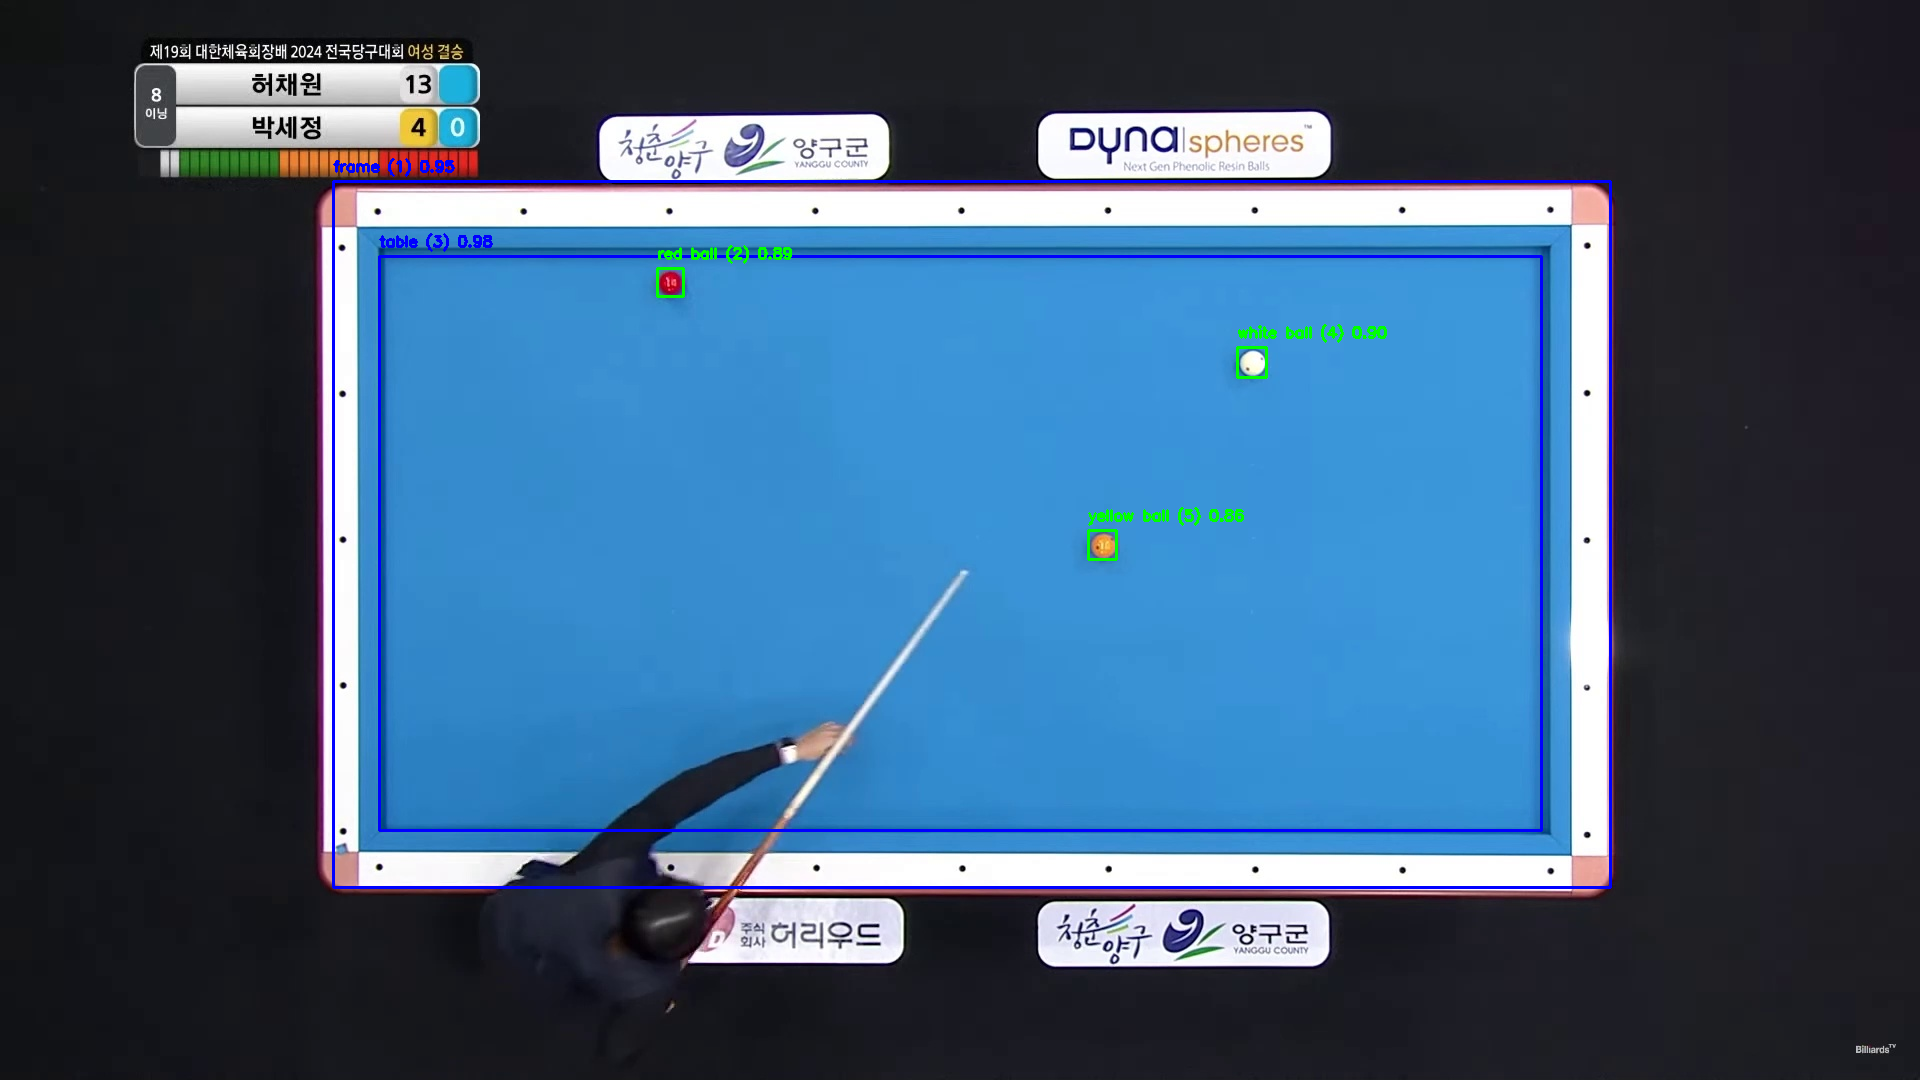

In [ ]:
import cv2
from ultralytics import YOLO  # YOLOv8를 사용하여 객체 검출
from google.colab.patches import cv2_imshow  # Colab 환경에서 이미지 표시용

# 사전학습된 모델 가져오기
model = YOLO("/content/drive/MyDrive/qpit_prj/data/best_Mansoon.pt")

# 이미지 읽기(추후 사용자가 보내준 이미지를 읽는 방법으로 수정필요)
image_path = '/content/drive/MyDrive/Billiard/Input_mp4/frames/single_frame.jpg'
image = cv2.imread(image_path)

# YOLO 모델로 이미지 분석
results = model(image)

# 클래스 이름 확인
class_names = model.names  # 모델에 저장된 클래스 이름들

# 이미지 복사본 생성 (결과를 그리기 위해)
output_image = image.copy()

# table 객체 정보 (table을 ball 안에서만 인정하기 위해 사용)
table_box = None

# 결과에서 객체 정보 추출
for detection in results[0].boxes:
    # 검출된 객체의 좌표, 클래스 ID 및 신뢰도
    box = detection.xyxy[0].tolist()  # [x1, y1, x2, y2]
    class_id = int(detection.cls[0])  # 클래스 ID
    confidence = detection.conf[0]  # 신뢰도

    # 클래스 이름 가져오기
    class_name = class_names[class_id]

    # 클래스 이름 출력
    print(f"Class_ID: {class_id}, Class_Name: {class_name}, Confidence: {confidence:.2f}, Box: {box}")

    # 'table' 객체를 찾으면 box 저장
    if class_name == 'table':
        table_box = box  # table의 좌표를 저장
        cv2.rectangle(output_image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 0, 255), 2)
        text = f"{class_name} ({class_id}) {confidence:.2f}"
        cv2.putText(output_image, text, (int(box[0]), int(box[1] - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

# table이 감지된 경우, table 내의 특정 ball만 인정하고 나머지는 그대로 처리
if table_box is not None:
    # table의 경계 정보
    table_x1, table_y1, table_x2, table_y2 = table_box

    # CSV 파일에 쓸 내용 준비
    detected_objects = []

    # white ball, red ball, yellow ball만 table 내에 있을 경우 박스를 그려줌
    for detection in results[0].boxes:
        box = detection.xyxy[0].tolist()  # [x1, y1, x2, y2]
        class_id = int(detection.cls[0])  # 클래스 ID
        confidence = detection.conf[0]  # 신뢰도

        # 클래스 이름 가져오기
        class_name = class_names[class_id]

        # ball 객체인 경우
        if class_name in ['white ball', 'red ball', 'yellow ball']:
            ball_x1, ball_y1, ball_x2, ball_y2 = box

            # ball이 table 안에 있는지 확인
            if (ball_x1 >= table_x1 and ball_y1 >= table_y1 and ball_x2 <= table_x2 and ball_y2 <= table_y2):
                # table 안에 있을 경우, 박스를 그림
                cv2.rectangle(output_image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
                text = f"{class_name} ({class_id}) {confidence:.2f}"
                cv2.putText(output_image, text, (int(box[0]), int(box[1] - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

                # CSV에 필요한 데이터 저장
                detected_objects.append([class_id, class_name, confidence, box])
            """
            else:
                # table 밖에 있을 경우, 박스를 빨간색으로 그림
                cv2.rectangle(output_image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 0, 255), 2)
                text = f"{class_name} ({class_id}) {confidence:.2f}"
                cv2.putText(output_image, text, (int(box[0]), int(box[1] - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            """
        else:
            # 'ball'이 아닌 객체는 그냥 박스를 그려줌
            cv2.rectangle(output_image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0), 2)
            text = f"{class_name} ({class_id}) {confidence:.2f}"
            cv2.putText(output_image, text, (int(box[0]), int(box[1] - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
            # CSV에 필요한 데이터 저장
            detected_objects.append([class_id, class_name, confidence, box])

    # CSV 파일로 저장(대상은 table내에 있는 공만 대상으로 저장)
    with open('/content/drive/MyDrive/qpit_prj/data/detected_objects.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Class_ID", "Class_Name", "Confidence", "Box"])
        writer.writerows(detected_objects)

# 결과 이미지 표시
cv2_imshow(output_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


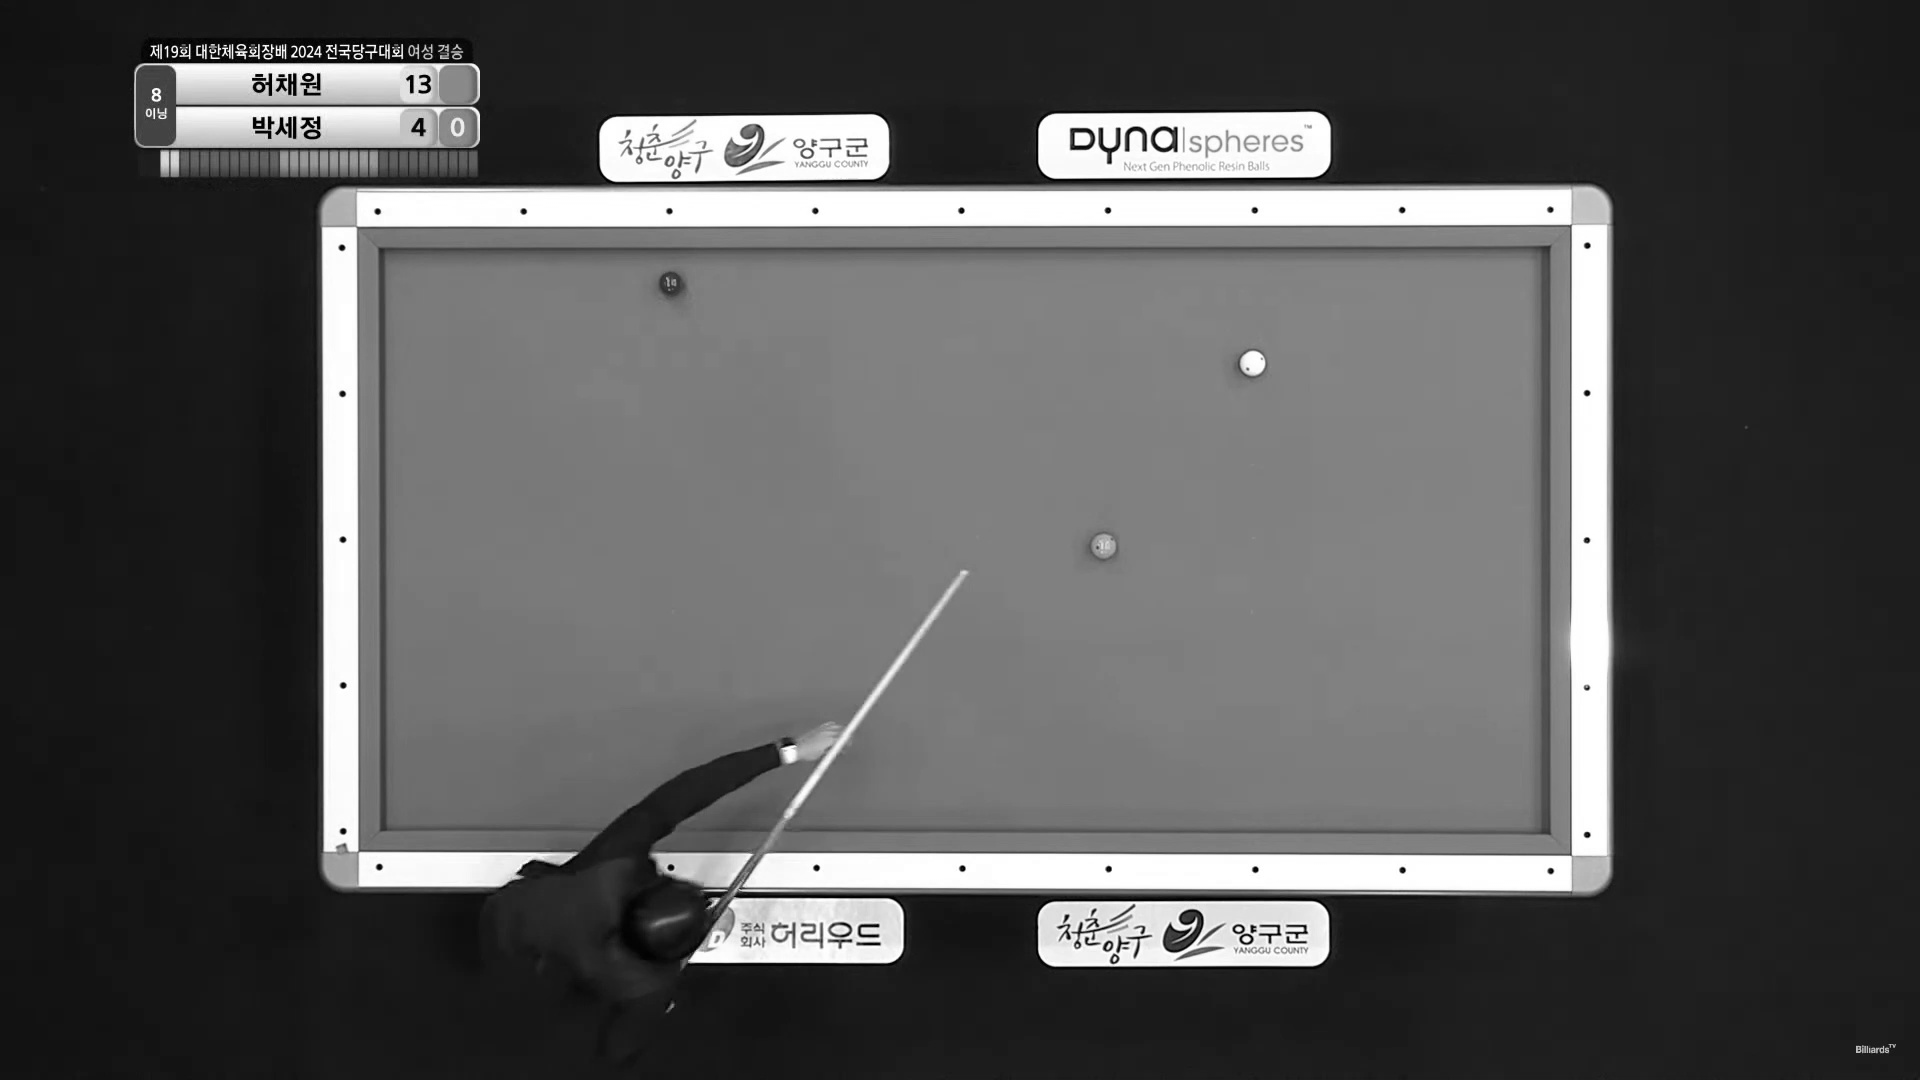

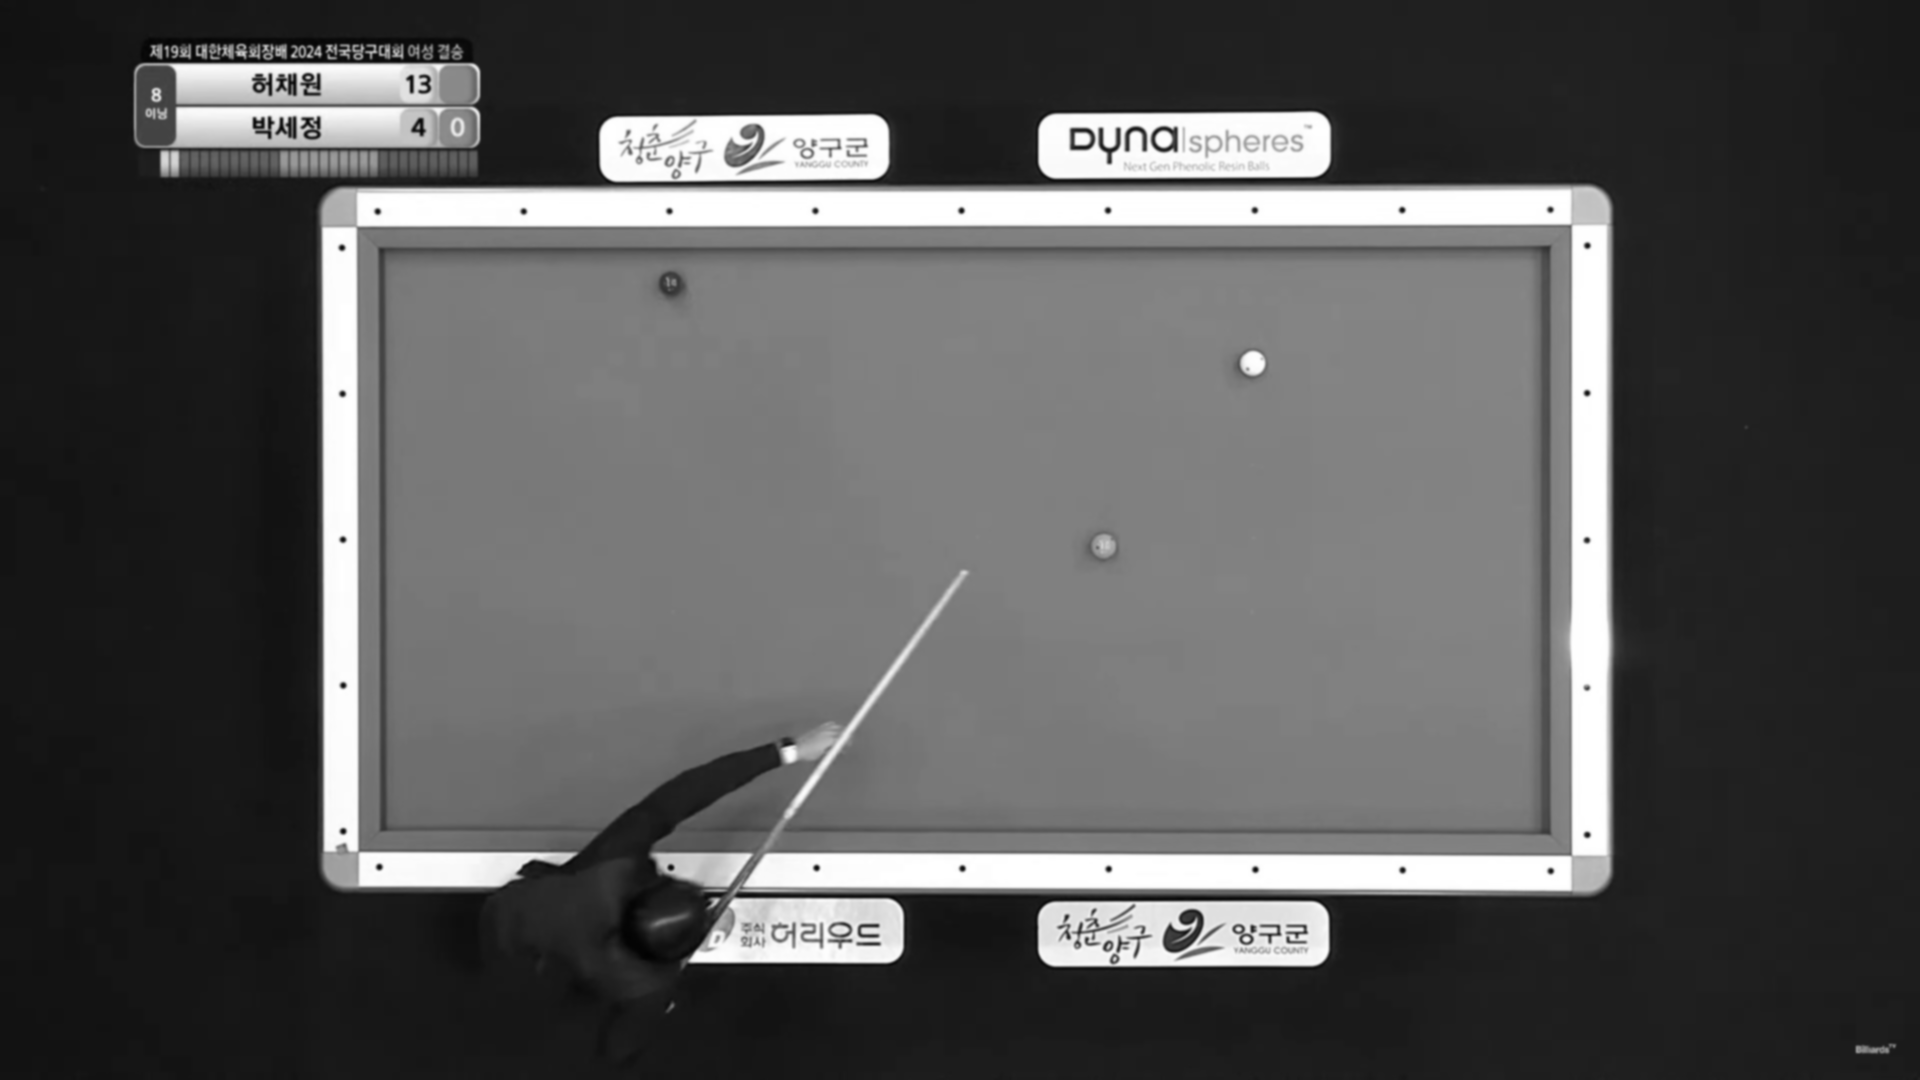

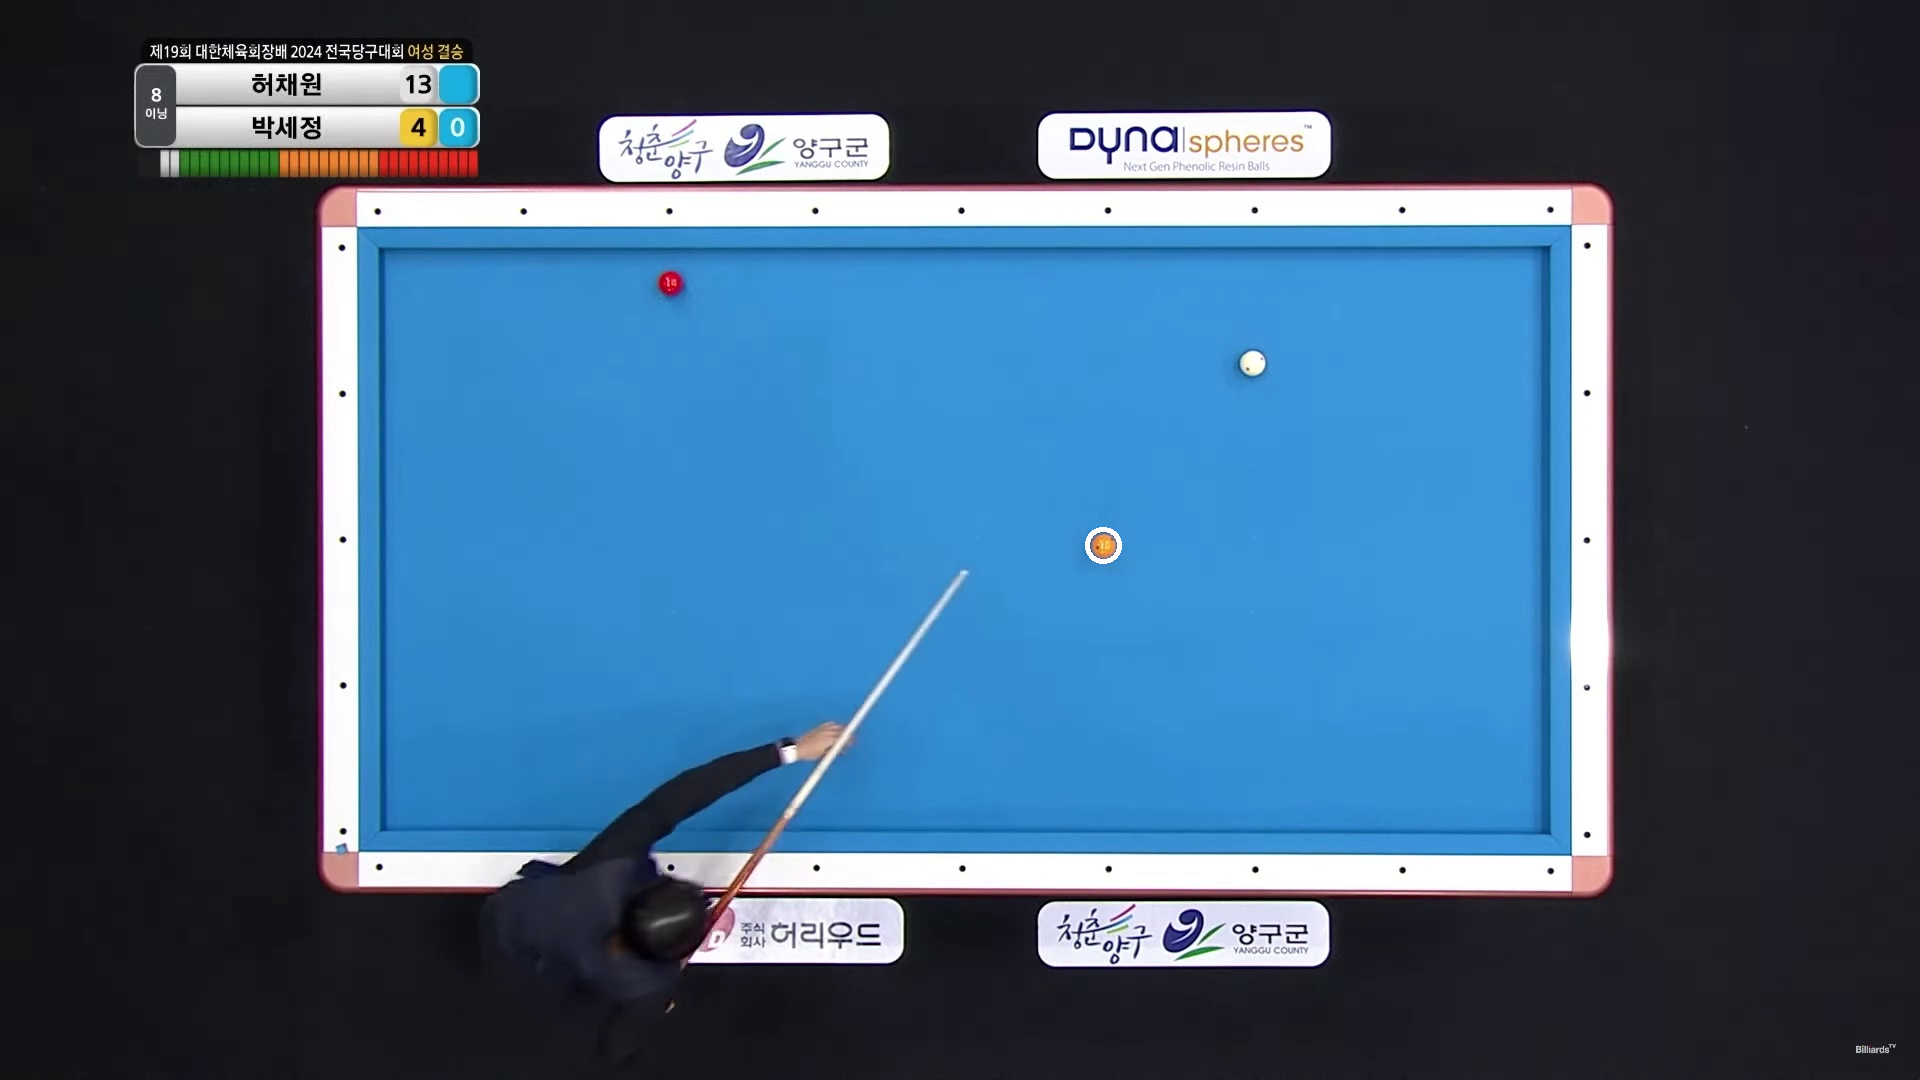

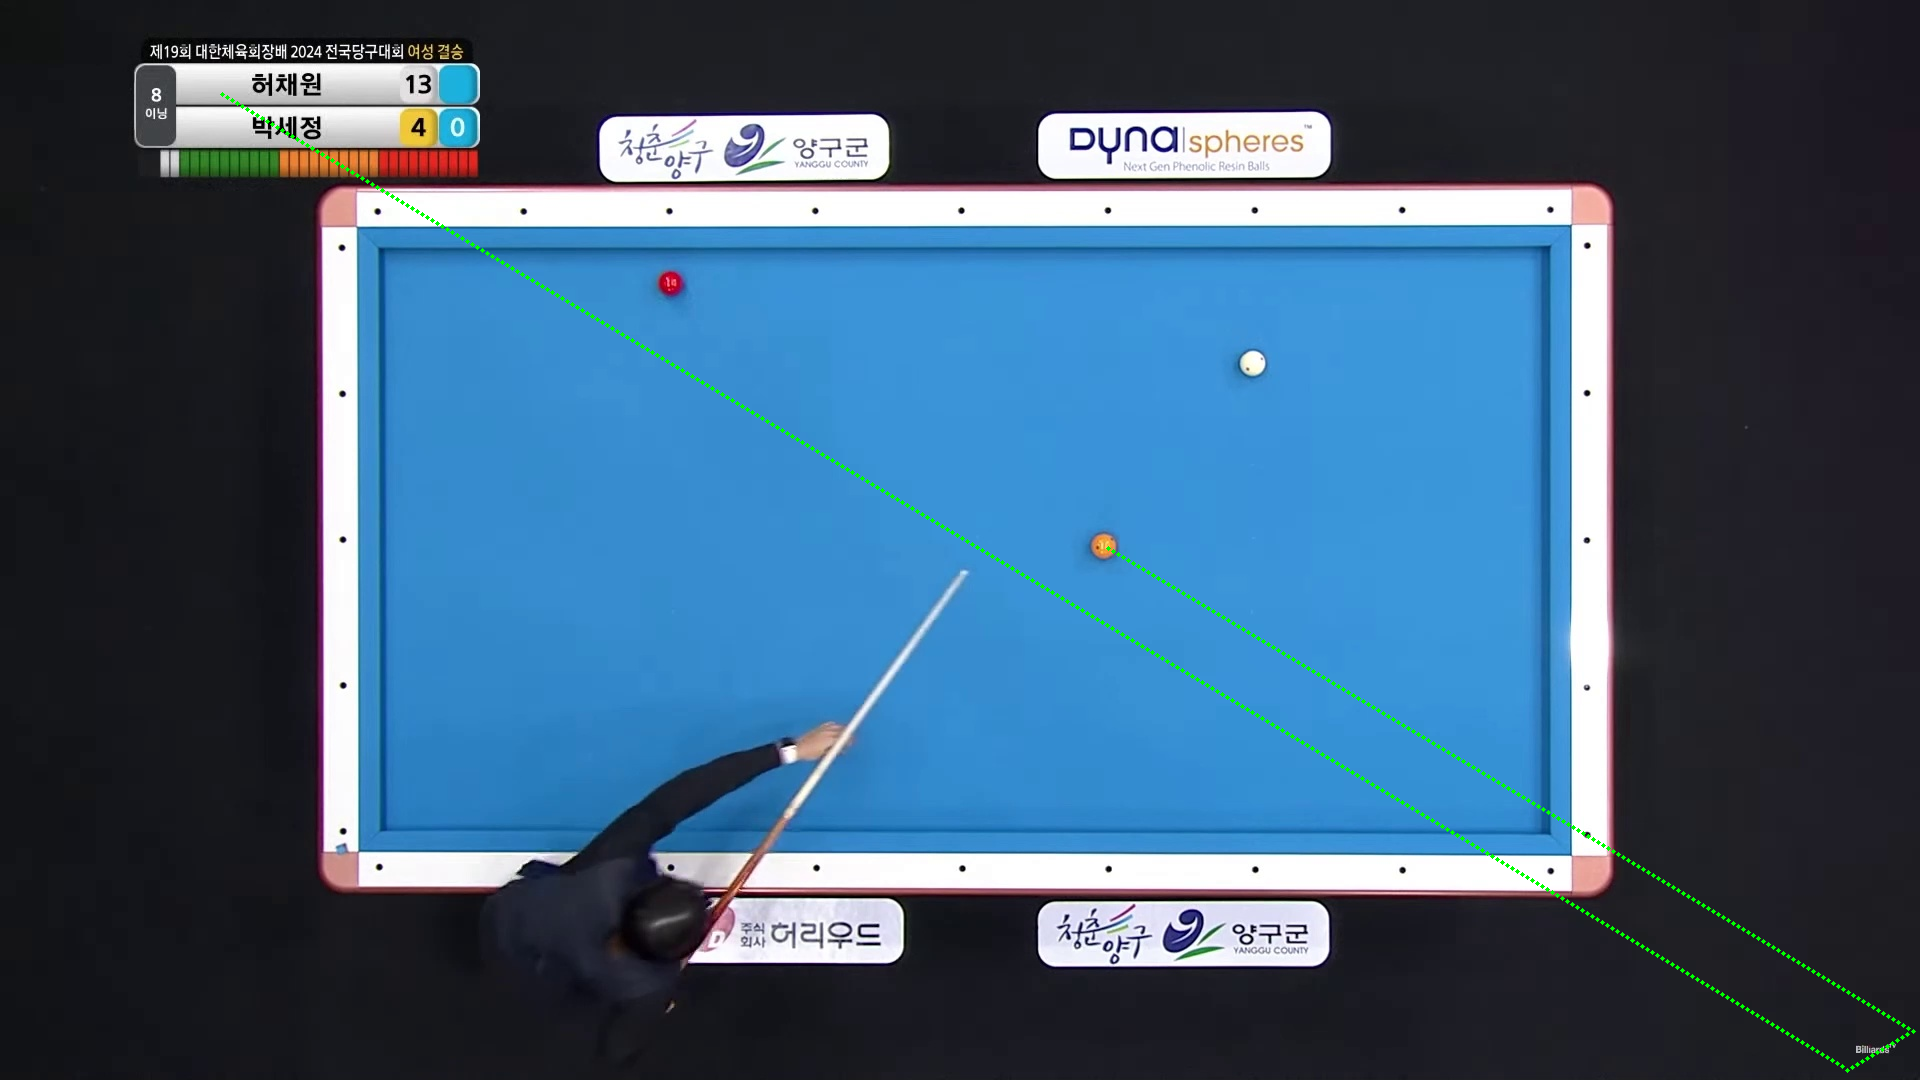

In [4]:
#--------------------------------------------------------
# 내공을 정하고, 그공을 탐지한후, 경로를 그려본 기능
#--------------------------------------------------------

import cv2
import numpy as np
import pymunk
from pymunk import Vec2d
from google.colab.patches import cv2_imshow

# 이미지를 불러오기
image = cv2.imread('/content/drive/MyDrive/Billiard/Input_mp4/frames/single_frame.jpg')
original = image.copy()  # 원본 이미지 백업

# Pymunk 물리 시뮬레이션 공간 초기화 함수
def setup_physics(space, bounds):
    """
    Pymunk 물리 공간에 당구대 벽과 공을 설정합니다.
    """
    # 중력을 (0, 0)으로 설정하여 당구 공의 움직임만 시뮬레이션
    space.gravity = (0, 0)

    # 고정된 벽을 추가 (당구대 경계)
    width, height = bounds
    static_lines = [
        pymunk.Segment(space.static_body, (0, 0), (width, 0), 1),     # 상단 벽
        pymunk.Segment(space.static_body, (0, 0), (0, height), 1),    # 좌측 벽
        pymunk.Segment(space.static_body, (width, 0), (width, height), 1),  # 우측 벽
        pymunk.Segment(space.static_body, (0, height), (width, height), 1)  # 하단 벽
    ]

    for line in static_lines:
        line.elasticity = 1.0  # 완전 탄성 충돌로 설정
        space.add(line)  # 물리 공간에 벽 추가

# 공을 OpenCV로 탐지하는 함수
def detect_white_ball(image):
    """
    OpenCV를 사용하여 흰 공을 탐지합니다.
    """
    # 이미지를 그레이스케일로 변환
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    cv2_imshow(gray)  # 변환된 이미지를 Colab에 출력

    # 블러링을 적용하여 노이즈 감소
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    cv2_imshow(blurred)  # 블러된 이미지를 Colab에 출력

    # 허프 서클 변환으로 원 탐지
    circles = cv2.HoughCircles(
        blurred,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=30,
        param1=50,
        param2=30,
        minRadius=10,
        maxRadius=30
    )
    cv2_imshow(circles)  # 탐지된 원 정보를 Colab에 출력

    # 원이 탐지된 경우
    if circles is not None:
        circles = np.uint16(np.around(circles))  # 정수로 반올림
        for circle in circles[0, :]:
            x, y, r = circle  # 원의 중심 좌표(x, y)와 반지름(r)
            # 탐지된 공을 표시
            cv2.circle(image, (x, y), r, (255, 255, 255), 3)  # 공의 경계를 흰색 원으로 그림
            cv2_imshow(image)  # 업데이트된 이미지를 Colab에 출력

            return (x, y), r  # 탐지된 공의 위치와 반지름 반환
    return None, None  # 탐지 실패 시 None 반환

# 경로를 시뮬레이션하는 함수
def simulate_bounce_path(space, start_pos, velocity, bounds, max_bounces):
    """
    지정된 초기 조건으로 공의 이동 경로를 시뮬레이션합니다.
    """
    # 공의 물리적 속성을 정의
    body = pymunk.Body(mass=1, moment=10)  # 질량과 관성을 설정
    body.position = start_pos  # 시작 위치
    body.velocity = velocity  # 초기 속도 설정
    radius = 10  # 공의 반지름
    ball = pymunk.Circle(body, radius)
    ball.elasticity = 1.0  # 완전 탄성 충돌
    space.add(body, ball)  # 물리 공간에 공 추가

    # 시뮬레이션 및 경로 기록
    trajectory_points = []  # 공의 경로를 저장할 리스트
    bounces = 0  # 벽에 부딪힌 횟수 초기화
    for _ in range(500):  # 500 스텝 동안 시뮬레이션 실행
        space.step(0.01)  # 시뮬레이션 시간 간격
        trajectory_points.append((int(body.position.x), int(body.position.y)))  # 현재 위치 추가

        # 벽과 충돌 확인 (경계 근처인지 확인)
        if (body.position.x <= 0 or body.position.x >= bounds[0] or
            body.position.y <= 0 or body.position.y >= bounds[1]):
            bounces += 1

        # 최대 충돌 횟수에 도달하면 종료
        if bounces >= max_bounces:
            break

    return trajectory_points  # 경로 반환

# 메인 시뮬레이션 실행
bounds = (image.shape[1], image.shape[0])  # 이미지의 가로(width)와 세로(height) 크기
space = pymunk.Space()  # Pymunk 공간 초기화
setup_physics(space, bounds)  # 물리적 환경 설정

# 흰 공 탐지 및 경로 시뮬레이션
start_pos, radius = detect_white_ball(original)
if start_pos:  # 공이 탐지된 경우
    velocity = (500, 300)  # 초기 속도 벡터
    max_bounces = 4  # 최대 충돌 횟수
    trajectory = simulate_bounce_path(space, start_pos, velocity, bounds, max_bounces)

    # 이미지에 경로 표시
    for point in trajectory:
        cv2.circle(image, point, 2, (0, 255, 0), -1)  # 경로를 초록색 점으로 표시

# 결과 출력
cv2_imshow(image)  # 결과 이미지를 Colab에 출력
cv2.waitKey(0)  # 키 입력 대기
cv2.destroyAllWindows()  # 모든 OpenCV 창 닫기
